# Data for the C3 Supernova fields
## 2-Point Correlation Function

### The 2-point correlation function, ξ(θ), is a statistical tool used in astronomy to quantify the clustering of galaxies. It measures the excess probability of finding a pair of galaxies separated by an angle θ compared to a random distribution.


In [128]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline

import halomod as hm
import hmf


#%matplotlib inline
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
#plt.rc('font',**{'family':'serif','size':18})
#plt.rc('text', usetex=True)

In [129]:
home_dir = os.path.expanduser('~')
# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


fits_file_path = os.path.join(thesis_path, "table")  


t= Table.read(fits_file_path)

#t= t[::5]  # Making sample smaller so my computer can handle it

t

id_1,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class,z,SM,

In [130]:
"""home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')


fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)


masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits") 
t3= Table.read(masked)

t=join(t,t3,keys='id')
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')
"""

fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)


Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


In [131]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

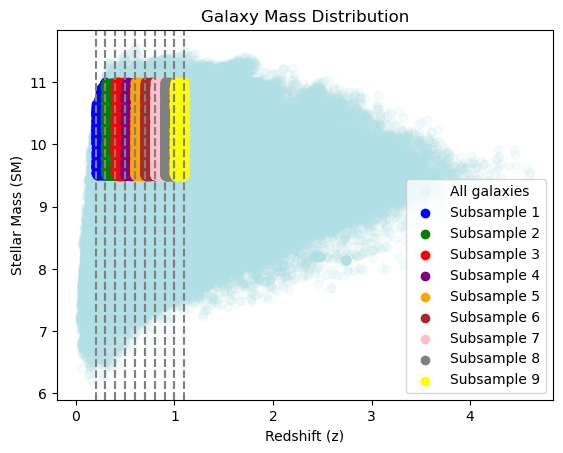

Subsample 1: N = 1215
  z_mean: 0.25
  SM_mean: 10.25
  z_min: 0.2

Subsample 2: N = 2157
  z_mean: 0.35
  SM_mean: 10.25
  z_min: 0.3

Subsample 3: N = 2562
  z_mean: 0.45
  SM_mean: 10.25
  z_min: 0.4

Subsample 4: N = 2848
  z_mean: 0.55
  SM_mean: 10.25
  z_min: 0.5

Subsample 5: N = 4284
  z_mean: 0.6499999999999999
  SM_mean: 10.25
  z_min: 0.6

Subsample 6: N = 4641
  z_mean: 0.75
  SM_mean: 10.25
  z_min: 0.7

Subsample 7: N = 5311
  z_mean: 0.8500000000000001
  SM_mean: 10.25
  z_min: 0.8

Subsample 8: N = 5842
  z_mean: 0.95
  SM_mean: 10.25
  z_min: 0.9

Subsample 9: N = 4523
  z_mean: 1.05
  SM_mean: 10.25
  z_min: 1.0



In [132]:
class Subsample:
    def __init__(self, z_min, z_max, SM_min, SM_max):
        self.z_min = z_min
        self.z_max = z_max
        self.SM_min = SM_min
        self.SM_max = SM_max
        self.info = {}  # Empty dictionary to store information

        # Add relevant information for R_0 calculation (e.g., delta, A, delta_z)
        self.info['delta'] = None  # Placeholder for delta
        self.info['A'] = None  # Placeholder for A
        # self.info['A'] = np.zeros()
        self.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        
       

    def apply(self, data):
        """
        Selects data points within the subsample region.

        Args:
            data: A dictionary containing data columns like 'z' and 'SM'.

        Returns:
            A boolean mask for the subsample selection.
        """
        return (data['z'] > self.z_min) & (data['z'] <= self.z_max) & \
               (data['SM'] > self.SM_min) & (data['SM'] <= self.SM_max)
    
    
    
# Define z and SM ranges
z_values = np.array([ 0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,1.0, 1.1])  ### be careful about completness issues, maybe stop at 0.4 for high SM

#z_values = np.array([ 0.4,0.6,0.8, 1.0, 1.2, 1.4,1.6,1.8])

SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM

#SM_range = np.linspace(8, 11, num=4) 



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = Subsample(z_min, z_max, SM_min, SM_max)
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',color='powderblue',alpha=0.1)

# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']
num_colors = len(colors)


for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i % num_colors])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()
    

In [133]:
print(len(subsamples))

9


In [134]:

class CorrelationFunction:
    def __init__(self, cat, randoms, config, rr=None):
        self.cat = cat
        self.randoms = randoms
        self.config = config

        # Create TreeCorr catalogs
        self.data = treecorr.Catalog(ra=cat['ra'], dec=cat['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)
        self.rand = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)

        # Create TreeCorr correlation functions
        self.dd = treecorr.NNCorrelation(**config)
        self.rr = treecorr.NNCorrelation(**config)
        self.dr = treecorr.NNCorrelation(**config)
        
    #def process_rand(self):
        #self.rr.process(self.rand) ###????maybe here problem?

    def process(self):
        self.dd.process(self.data)
        self.dr.process(self.data, self.rand)
        self.rr.process(self.rand)

    def calculate_w_theta(self):
        theta = np.exp(self.dd.meanlogr)
        w, varw = self.dd.calculateXi(rr=self.rr, dr=self.dr) 
        
        return w, varw, theta , self.rr
    

    """def power_law(self,theta, A, delta):
        self.A=A
        self.theta=theta
        self.delta= delta
        
        return A * theta**delta"""

In [135]:
randoms = t2
#randoms = t2[::1000]

In [136]:
"""c1 = CorrelationFunction(catalog, randoms, config)
c1.process()
w, varw, theta, rr = c1.calculate_w_theta()
f1= c1.power_law(theta,0.02,-0.8)"""



'c1 = CorrelationFunction(catalog, randoms, config)\nc1.process()\nw, varw, theta, rr = c1.calculate_w_theta()\nf1= c1.power_law(theta,0.02,-0.8)'

In [137]:
"""plt.plot(theta, f1, label='Power Law Fit')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$w(\theta)$')
plt.title("Power Law Fit for 2PCF")
plt.yscale('log')
plt.xscale('log')
       
plt.show()"""

'plt.plot(theta, f1, label=\'Power Law Fit\')\nplt.xlabel(r\'$\theta$ (degrees)\')\nplt.ylabel(r\'$w(\theta)$\')\nplt.title("Power Law Fit for 2PCF")\nplt.yscale(\'log\')\nplt.xscale(\'log\')\n       \nplt.show()'

In [138]:
"""subsample = (t['z'] > 0.5) & (t['z'] <= 0.6) & (t['SM'] > 10) & (t['SM'] <= 10.5)
subset = t[subsample]
randoms = t2[::1000]

corr_func = CorrelationFunction(subset, randoms, config)


corr_func.process_rand() #crashes here
corr_func.process() # and crashes here too
w, varw, theta, rr = corr_func.calculate_w_theta()


# Save the data to a text file, separating columns with commas
np.savetxt("w.txt", w, delimiter=",")
np.savetxt("varw.txt", w, delimiter=",")
np.savetxt("theta.txt", w, delimiter=",")
np.savetxt("rr.txt", w, delimiter=",")
"""

'subsample = (t[\'z\'] > 0.5) & (t[\'z\'] <= 0.6) & (t[\'SM\'] > 10) & (t[\'SM\'] <= 10.5)\nsubset = t[subsample]\nrandoms = t2[::1000]\n\ncorr_func = CorrelationFunction(subset, randoms, config)\n\n\ncorr_func.process_rand() #crashes here\ncorr_func.process() # and crashes here too\nw, varw, theta, rr = corr_func.calculate_w_theta()\n\n\n# Save the data to a text file, separating columns with commas\nnp.savetxt("w.txt", w, delimiter=",")\nnp.savetxt("varw.txt", w, delimiter=",")\nnp.savetxt("theta.txt", w, delimiter=",")\nnp.savetxt("rr.txt", w, delimiter=",")\n'

In [139]:
# Create CorrelationFunction objects with the same configuration
corr_funcs = []

for i, catalog in enumerate(catalogs):


    corr_func = CorrelationFunction(catalog, randoms, config)
    corr_func.process()
    w, varw, theta, rr = corr_func.calculate_w_theta()

    # Append the calculated values to the corresponding subsample's info dictionary
    subsamples[i].info['w'] = w
    subsamples[i].info['varw'] = varw
    subsamples[i].info['theta'] = theta
    subsamples[i].info['rr'] = rr
    corr_funcs.append(corr_func)
  
"""  
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])
    print(f"Subsample {i+1}: N = {N}")
    print(f"  w: {subsample.info['w']}")
    print(f"  theta: {subsample.info['theta']}")
"""

'  \nfor i, subsample in enumerate(subsamples):\n    N = len(catalogs[i])\n    print(f"Subsample {i+1}: N = {N}")\n    print(f"  w: {subsample.info[\'w\']}")\n    print(f"  theta: {subsample.info[\'theta\']}")\n'

In [140]:
ws= []
varws= []
thetas= []
results= []
# Process and calculate w(theta) for each subsample
for i, corr_func in enumerate(corr_funcs):
    w, varw, theta, rr = corr_func.calculate_w_theta()
    ws.append(w)
    varws.append(varw)
    thetas.append(theta)
    
    # Create a dictionary for this iteration
    iteration_results = {
            "w": w,
            "varw": varw,
            "theta": theta}

        # Append the iteration results to the main list
    results.append(iteration_results)


In [141]:
print(len(thetas))

9


In [142]:
"""for i, subsample in enumerate(subsamples):
    plt.scatter( subsample.info['theta'], subsample.info['w'], label=f"Subsample {i+1}")
    plt.xlabel(r' $ \theta$ (degrees)')  #correlation function w
    plt.ylabel(r' $w(\theta)$') # angular separation theta
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)

    plt.show()"""

'for i, subsample in enumerate(subsamples):\n    plt.scatter( subsample.info[\'theta\'], subsample.info[\'w\'], label=f"Subsample {i+1}")\n    plt.xlabel(r\' $ \theta$ (degrees)\')  #correlation function w\n    plt.ylabel(r\' $w(\theta)$\') # angular separation theta\n    plt.legend()\n    plt.yscale(\'log\')\n    plt.xscale(\'log\')\n    plt.grid(True)\n\n    plt.show()'

In [143]:
"""
# Assuming subsamples is a list of dictionaries containing 'w' and 'theta' keys
for i, subsample in enumerate(subsamples):
  
    plt.scatter( thetas[i], ws[i], label=f"Subsample {i+1}")
    plt.xlabel(r' $ \theta$ (degrees)')  #correlation function w
    plt.ylabel(r' $w(\theta)$') # angular separation theta
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)

    plt.show()
    """


'\n# Assuming subsamples is a list of dictionaries containing \'w\' and \'theta\' keys\nfor i, subsample in enumerate(subsamples):\n  \n    plt.scatter( thetas[i], ws[i], label=f"Subsample {i+1}")\n    plt.xlabel(r\' $ \theta$ (degrees)\')  #correlation function w\n    plt.ylabel(r\' $w(\theta)$\') # angular separation theta\n    plt.legend()\n    plt.yscale(\'log\')\n    plt.xscale(\'log\')\n    plt.grid(True)\n\n    plt.show()\n    '

In [144]:
"""fit= corr_func.power_law(theta, A=0.01)
err=np.sqrt(varw)"""

'fit= corr_func.power_law(theta, A=0.01)\nerr=np.sqrt(varw)'

In [145]:
"""

def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
   

    # Fit the power law using curve_fit with initial guesses
    popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print()

    return amplitude_at_1deg


    
As = []
for i, catalog in enumerate(catalogs):
    A = fit_and_plot_power_law(thetas[i],ws[i], i + 1)
    
    plt.scatter(thetas[i],ws[i], label=f"Subsample {catalog}")
    plt.plot(thetas[i], power_law(thetas[i], *popt), label='Power Law Fit')
    plt.xlabel(r' $ \theta$ (degrees)')
    plt.ylabel(r' $w(\theta)$')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()
    
    subsample.info['Amplitude'] = fit_and_plot_power_law(theta, w, catalog)
    subsamples.append(subsample)
    
    As.append(A)
"""

'\n\ndef power_law(theta, A, delta):\n    return A * theta**delta\n\n\ndef fit_and_plot_power_law(theta, w, cat):\n   \n\n    # Fit the power law using curve_fit with initial guesses\n    popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])\n\n    # Extract fitted parameters\n    A_fit = popt[0]\n    delta_fit = popt[1]\n\n    # Calculate amplitude at 1 degree\n    amplitude_at_1deg = power_law(1, A_fit, delta_fit)\n\n    # Print fit parameters\n    print(f"Subsample {cat}, Power-law Fit Parameters")\n    print(f" Amplitude at 1°:", amplitude_at_1deg)\n    print()\n\n    return amplitude_at_1deg\n\n\n    \nAs = []\nfor i, catalog in enumerate(catalogs):\n    A = fit_and_plot_power_law(thetas[i],ws[i], i + 1)\n    \n    plt.scatter(thetas[i],ws[i], label=f"Subsample {catalog}")\n    plt.plot(thetas[i], power_law(thetas[i], *popt), label=\'Power Law Fit\')\n    plt.xlabel(r\' $ \theta$ (degrees)\')\n    plt.ylabel(r\' $w(\theta)$\')\n    plt.yscale(\'log\')\n    plt.xscale(\'log\

In [146]:
print(subsample.info['A'])

None


Subsample 1, Power-law Fit Parameters
 Amplitude at 1°: 0.034370630266919396
 Delta: -0.5867679541476764

Subsample 2, Power-law Fit Parameters
 Amplitude at 1°: 0.005819197513696665
 Delta: -0.9158239616265574

Subsample 3, Power-law Fit Parameters
 Amplitude at 1°: 0.001613738955996481
 Delta: -1.0790545894631958

Subsample 4, Power-law Fit Parameters
 Amplitude at 1°: 0.006349966790418366
 Delta: -0.7162766453661732

Subsample 5, Power-law Fit Parameters
 Amplitude at 1°: 0.014354770070104078
 Delta: -0.6869244776969029

Subsample 6, Power-law Fit Parameters
 Amplitude at 1°: 0.005324769905970283
 Delta: -0.9369690670315347

Subsample 7, Power-law Fit Parameters
 Amplitude at 1°: 0.002014207464986368
 Delta: -1.017935378348672

Subsample 8, Power-law Fit Parameters
 Amplitude at 1°: 0.005161266958325574
 Delta: -0.8033098846617149

Subsample 9, Power-law Fit Parameters
 Amplitude at 1°: 0.001011347919276743
 Delta: -1.127586926773251



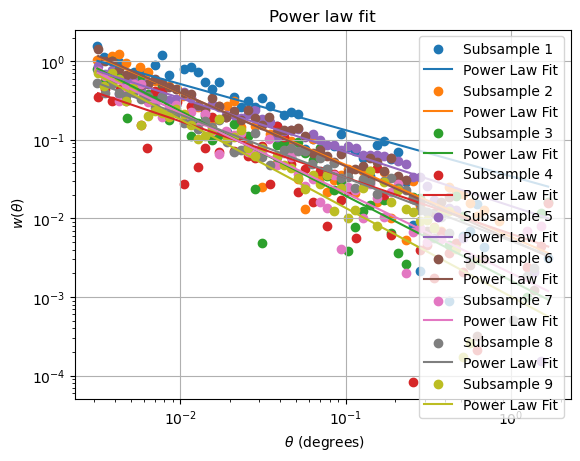

In [147]:
def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
    """
    Fits a power law to the provided 2PCF data and plots the results.

    Args:
        theta (np.ndarray): Angular separation bins.
        w (np.ndarray): 2PCF values for the current catalog.
        cat (int): Identifier for the current catalog (used for labeling).
    """

    # Fit the power law using curve_fit with initial guesses
    #popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])
    popt, pcov = curve_fit(power_law, subsample.info['theta'], subsample.info['w'], p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print(f" Delta:", delta_fit)
    print()

    # Plot the data and fitted curve for this catalog
    #plt.scatter(theta, w, label=f"Subsample {cat}")
    #plt.plot(theta, power_law(theta, *popt), label='Power Law Fit')
    
    plt.scatter(subsample.info['theta'], subsample.info['w'], label=f"Subsample {cat}")
    plt.plot(subsample.info['theta'], power_law(subsample.info['theta'], *popt), label='Power Law Fit')


    return amplitude_at_1deg, delta_fit

"""
As = []
for i, catalog in enumerate(catalogs):
    # Call fit_and_plot_power_law to get fit parameters and plot for each catalog
    A = fit_and_plot_power_law(thetas[i], ws[i], i + 1)
    
    As.append(A)"""
    
deltas = []
As = []
for i, subsample in enumerate(subsamples):
    #A, delta = fit_and_plot_power_law(thetas[i], ws[i], i + 1)
    #     subsamples[i].info['w']
    A, delta = fit_and_plot_power_law(subsamples[i].info['theta'][i], subsamples[i].info['w'], i + 1)
    subsamples[i].info['A'] = A
    subsamples[i].info['delta'] = delta
    

    As.append(A)
    deltas.append(delta)
    
    
    

# Additional plotting customizations (labels, grid, etc.) can be added here
plt.title("Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.savefig("Power law fit")

plt.grid(True)
plt.legend()
plt.show()


In [148]:
#print(As)

In [149]:
"""for subsample in subsamples:
    subsample.A = np.array(As)  # Convert As to a numpy array
    subsample.delta = np.array(deltas)  # Convert deltas to a numpy array"""


'for subsample in subsamples:\n    subsample.A = np.array(As)  # Convert As to a numpy array\n    subsample.delta = np.array(deltas)  # Convert deltas to a numpy array'

In [150]:
"""for subsample in subsamples:
    subsample.info['A'] = np.array(As)  # Convert As to a numpy array
    subsample.info['delta'] = np.array(deltas)  # Convert deltas to a numpy array"""

"for subsample in subsamples:\n    subsample.info['A'] = np.array(As)  # Convert As to a numpy array\n    subsample.info['delta'] = np.array(deltas)  # Convert deltas to a numpy array"

In [151]:
print(subsample.info['A'])
print(subsample.info['delta'])


0.001011347919276743
-1.127586926773251


In [152]:
class Cosmology:
    def __init__(self, H0, Omega0):
        self.H0 = H0
        self.Omega0 = Omega0

    def x(self, z):
        def integrand(z_prime):
            return ((1 + z_prime)**3 + self.Omega0 - 1)**(-0.5)
        result, _ = quad(integrand, 0, z)
        return result * (self.Omega0**(-0.5) * self.H0)

    def F(self, z):
        return 1

    def P(self, z):
        return np.sqrt(self.Omega0) * np.sqrt((1 + z) ** 3 + self.Omega0**(-1) - 1)

In [153]:
# class that calculates the comoving correlation length (R_0) for a subsample based on its properties

class SubsampleAnalysis:
    def __init__(self, delta, A, z_mean, delta_z, H_gamma=3.68, c=299792.458):
        self.delta = delta
        self.A = A
        self.z_mean = z_mean
        self.delta_z = delta_z
        self.H_gamma = H_gamma
        self.c = c

        # Assuming a standard cosmology
        self.cosmo = Cosmology(H0=70, Omega0=0.3)

    def calculate_r0(self):
        print(type(self.A))
        gamma = 1.8
        #gamma = (self.delta * -1) + 1
        print(gamma)
        numerator = self.c * self.A * self.delta_z

        denominator = self.cosmo.H0 * self.H_gamma * self.cosmo.x(self.z_mean) ** (1 - gamma) * self.cosmo.P(self.z_mean) * self.cosmo.F(self.z_mean)
        r0 = (numerator / denominator) ** (1 / gamma)
        
        return r0
    
    
     

In [154]:
r0_values = []
for subsample in subsamples:
    # Create a SubsampleAnalysis object with relevant information
    analysis = SubsampleAnalysis(subsample.info['delta'], subsample.info['A'],
                                  subsample.info['z_mean'], subsample.info['delta_z'] ,3.68, 299792.458)

    # Calculate R_0 for the subsample
    r0 = analysis.calculate_r0()
    #r0_values.append(r0)
    
    #r0_value = r0[0]  # Assuming r0 is a 1D array, access the first element
    r0_values.append(r0)

    # Print or store the R_0 value (optional)
    #print(f"Subsample: R_0: {r0_value:.4f} Mpc/h")

    # Print or store the R_0 value (optional)
    #print(f"Subsample: R_0: {r0:.4f} Mpc/h")

    """# Extract z_mean and R_0 values from the subsamples
    z_means = [subsample.info['z_mean'] for subsample in subsamples]
    sm_means = [subsample.info['SM_mean'] for subsample in subsamples]"""


<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8


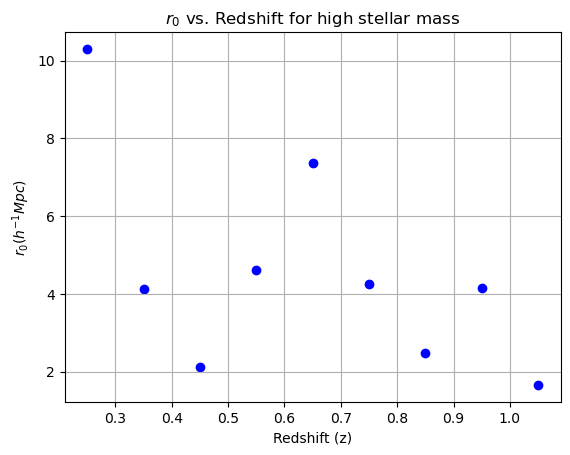

In [155]:
z_means = [subsample.info['z_mean'] for subsample in subsamples]

# Plot R_0 as a function of z_mean
plt.scatter(z_means, r0_values, marker='o', linestyle='-', color='blue')

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift for high stellar mass")
plt.grid(True)
plt.show()

In [156]:
colors = ['blue', 'red', 'green']
m = SM_mean_range
unique_sm_means = np.unique(SM_mean_range)
print(unique_sm_means)



for i in enumerate(m):
    z_means = [subsample.info['z_mean'] for subsample in subsamples]

    # Plot R_0 as a function of z_mean
    plt.scatter(z_means, r0_values, marker='o', linestyle='-', color=colors[i])

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift for high stellar mass")
plt.grid(True)
plt.show()

[10.25]


TypeError: list indices must be integers or slices, not tuple

In [ ]:
m = np.unique(SM_mean_range) # Get the unique SM values

# Define two distinct colors for the two SM ranges
colors = ['blue', 'red']  # You can customize these colors

# Separate data by the first two SM ranges (assuming two unique values)

data_by_sm = [{'z_mean': [], 'r0': []} for _ in m]  # Empty dictionaries for each SM range

for i, SM_mean in enumerate(SM_mean_range):
    if SM_mean in m:
        index = np.where(m == SM_mean_range)[0][0]  # Find index in unique_sm_means
        data_by_sm[index]['z_mean'].append(z_means[i])
        data_by_sm[index]['r0'].append(r0_values[i])

# Plot data for each SM range with different colors
for i, SM_mean in enumerate(SM_mean_range):
    z_mean_subset = data_by_sm[i]['z_mean']
    r0_subset = data_by_sm[i]['r0']
    label = f"SM_mean: {sm_range:.2f}"
    plt.scatter(z_mean_subset, r0_subset, label=label, marker='o', color=colors[i])

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift (Different Stellar Mass Ranges)")
#plt.savefig("r0_vs_redshift_for_high_SM.png")

plt.grid(True)
plt.legend()
plt.show()

 Higher Mass Galaxies: Typically, higher mass galaxies tend to have stronger clustering than lower mass galaxies. This means they are more likely to be found in groups and clusters.

Evolution with Redshift: Clustering of galaxies often increases with redshift, meaning galaxies were more clustered in the past compared to today.

## Halomod

* **Dark Matter Correlation Function:** This function describes how the density of dark matter is correlated at different spatial separations. It's a key ingredient in understanding the distribution of matter in the universe.
* **Galaxy Bias:** Galaxies are not perfectly tracers of the underlying dark matter distribution. Galaxy bias accounts for the fact that galaxies may preferentially form in regions of higher or lower dark matter density. 



1. **Calculate the Dark Matter Correlation Function:**
   - Use cosmological simulations or theoretical models (like the Halomod framework) to predict the dark matter correlation function, ξ_mm(r), as a function of separation (r).
2. **Incorporate Galaxy Bias:**
   - **Linear Bias:** For small-scale fluctuations, galaxy bias can often be approximated as a linear relationship:
      ξ_gg(r) = b^2 * ξ_mm(r) 
      where ξ_gg(r) is the galaxy-galaxy correlation function and 'b' is the galaxy bias parameter.
   - **Non-linear Bias:** On smaller scales, non-linear effects become important. These can be incorporated into the Halomod framework using more sophisticated bias models.





In [ ]:

nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values))
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
#gg.theta_min = np.min(thetas[0])*np.pi/180
#gg.theta_max = np.max(thetas[0])*np.pi/180
#gg.theta_num = len(thetas[0])

gg.theta_min = np.min(subsample.info['theta'][0])*np.pi/180
gg.theta_max = np.max(subsample.info['theta'][0])*np.pi/180

print(gg.angular_corr_gal)

In [ ]:
plt.errorbar(thetas[0], ws[0], fmt='o', label='without IC')

plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')


plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:
for i, subsample in enumerate(subsamples):
    
    #plt.errorbar(thetas[i],ws[i], fmt='o', label=f"Subsample {i+1}")#'without IC
    plt.errorbar(subsample.info['theta'], subsample.info['w'],  fmt='o',label=f"Subsample {i+1}")
    

plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')


plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:
"""
# Convert ws to a NumPy array
ws_np = np.array(ws)
ws_reshaped = ws_np.flatten()

print(len(ws_reshaped))
print(len(gg.angular_corr_matter))"""

In [ ]:
from scipy.optimize import curve_fit


# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)



"""
popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])


# Extract the best-fit bias parameter
bias = popt[0]
bias_error = np.sqrt(pcov[0, 0])


print(f" Bias: {bias:.3f} +/- {bias_error:.3f}")"""

In [ ]:


"""
high_sm_biases = [] #9.5 to 11 SM

for i, subsample in enumerate(subsamples):
    # Ensure compatibility in shapes:
    
    nz = hm.integrate_corr.flat_z_dist(subsample.z_min,subsample.z_max)
    gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin= subsample.z_min,zmax= subsample.z_max, z=subsample.info['z_mean'])
    print(subsample.z_min)
    gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
    gg.theta_min = np.min(subsample.info['theta'])*np.pi/180
    gg.theta_max = np.max(subsample.info['theta'])*np.pi/180
    gg.theta_num = len(thetas)
    
    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, subsample.info['w'][:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    high_sm_bias = popt[0]
    high_sm_bias_error = np.sqrt(pcov[0, 0])

     # Append bias and error to a list of tuples
    high_sm_biases.append((high_sm_bias, high_sm_bias_error))
    print(f"Bias: {high_sm_bias:.3f} +/- {high_sm_bias_error:.3f}")
# Create a NumPy array from the list of tuples
high_biases_array = np.array(high_sm_biases)

# Save the array to a text file
np.savetxt('high_sm_biases.txt', high_biases_array, delimiter=',')"""




####uncomment here!!!! 
"""
# Load the data from the text file
hb = np.loadtxt('high_sm_biases.txt', delimiter=',')

# Extract bias and error values from the loaded data
H_biases = hb[:, 0]
H_errors = hb[:, 1]"""

In [ ]:
"""low_sm_biases = [] #8 to 9.5 SM

for i in ws:
    # Ensure compatibility in shapes:
    ws_np = np.array(i)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    low_sm_bias = popt[0]
    low_sm_bias_error = np.sqrt(pcov[0, 0])

    # Append bias and error to a list of tuples
    low_sm_biases.append((low_sm_bias, low_sm_bias_error))

# Create a NumPy array from the list of tuples
low_biases_array = np.array(low_sm_biases)

# Save the array to a text file
np.savetxt('low_sm_biases.txt', low_biases_array, delimiter=',')"""






####uncomment here!!!! 

"""
# Load the data from the text file
lb = np.loadtxt('low_sm_biases.txt', delimiter=',')

# Extract bias and error values from the loaded data
L_biases = lb[:, 0]
L_errors = lb[:, 1]"""

In [ ]:
diff_sm_biases = [] #8 to 11 SM

for i in ws:
    # Ensure compatibility in shapes:
    ws_np = np.array(i)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    diff_sm_bias = popt[0]
    diff_sm_bias_error = np.sqrt(pcov[0, 0])

     # Append bias and error to a list of tuples
    diff_sm_biases.append((diff_sm_bias, diff_sm_bias_error))
    print(f"Bias: {diff_sm_bias:.3f} +/- {diff_sm_bias_error:.3f}")

# Create a NumPy array from the list of tuples
diff_sm_bias_array = np.array(diff_sm_biases)

# Save the array to a text file
np.savetxt('diff_sm_biases.txt', diff_sm_bias_array, delimiter=',')

    
# Load the data from the text file
diff = np.loadtxt('diff_sm_biases.txt', delimiter=',')

# Extract bias and error values from the loaded data
diff_biases = diff[:, 0]
diff_errors = diff[:, 1]

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]

# Plot bias vs. redshift

#plt.errorbar(redshifts, L_biases, label='Low Stellar Mass ',marker='o') # 8 to 9.5
#plt.errorbar(redshifts, H_biases, label='High Stellar Mass',marker='o') #9.5 to 11
plt.scatter(redshifts, diff_biases, label='Diff. Stellar Masses',marker='o')

plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

#plt.savefig("Bias as a Function of Redshift")

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()


### Interpreting the Bias:

* b > 1: Galaxies cluster more strongly than dark matter. This could be due to various physical processes like baryonic feedback or halo assembly bias.
* b < 1: Galaxies cluster less strongly than dark matter. This might be due to observational biases or specific galaxy populations.


The bias is naturally larger at earlier epochs of galaxy formation, as the first galaxies to form will collapse in the most overdense regions of space, which are biased (akin to mountain peaks being clustered). They further show that regardless of the initial amplitude of the bias factor, with time galaxies will become unbiased tracers of the mass distribution (b tends 1 as t tends to infinity).

In [ ]:
#for i, catalog in enumerate(catalogs):
for i, subsample in enumerate(subsamples):
   
   # plt.errorbar(thetas[i],ws[i], fmt='o', label=f"Subsample {i+1}")#without IC
    plt.errorbar(subsample.info['theta'], subsample.info['w'],  fmt='o',label=f"Subsample {i+1}")

    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter* H_biases[i],  label=f"bias {i+1}")


#plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
#plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')
for i, subsample in enumerate(subsamples):
    N = len(catalog)
    
    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

plt.title("CFs with biases fit")

plt.savefig("CFs with biases fit")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:


# Create a new figure for the bias vs. redshift plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Plot bias vs. redshift
redshifts = [subsample.info['z_mean'] for subsample in subsamples]  # Assuming z_mean is in subsample.info dictionary
plt.scatter(redshifts, H_biases, label='High SM',marker='o')  # Use colors list for consistent coloring
# Add labels and title
plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")


# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

## $r_0$ vs. Redshift (Different Stellar Mass Ranges

In [ ]:
print(r0_values)

In [ ]:
#m = SM_mean_range
m = np.unique(SM_mean_range) # Get the unique SM values

z= z_mean_range
print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)


In [ ]:
zm=np.array(zm).reshape(2,-1)
zm[:,0]

In [ ]:
#r0s_reshaped = np.reshape(r0_values, (len(m), len(z)))  # since r0s is a flattened array
r0s_reshaped = np.reshape(r0_values, (len(z), len(m))).T  # since r0s is a flattened array

#print(r0s_reshaped)

In [ ]:
print(len(r0_values))

In [ ]:
for i in range(len(m)):
    plt.plot(z, r0s_reshaped[i], label=f"SM = {m[i]:.1f}",marker='o')

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig("r0_vs_redshift_for_diff_SM.png")  
plt.show()

In [ ]:
for i in range(len(m)):
    sigma = [0.1 * z_mean + 1 for z_mean in z]  # is the rms error on each redshift
    plt.errorbar(z, r0s_reshaped[i], yerr=sigma, label=f"SM = {m[i]:.1f}",marker='o',capsize=7,)

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig("r0_vs_redshift_for_diff_SM_sigma.png")  
plt.show()

In [ ]:
diff_biases[20]

In [ ]:
for i in range(len(m)):
    plt.scatter(redshifts, diff_biases,  label=f"SM = {m[i]:.1f}",marker='o')
    

    

plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

#plt.savefig("Bias as a Function of Redshift")

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:

# Define the directory where you want to save the file
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3" 

# Create the directory if it doesn't exist
os.makedirs(directory_SN_C3, exist_ok=True) 

In [ ]:
import csv  # Import the csv module for convenient text file writing

results = []

for i, subsample in enumerate(subsamples):
    # Create a list/tuple to hold data for the current subsample
    subsample_data = [subsample.info['SM_mean'], subsample.info['z_mean'], diff_biases[i], r0_values[i]]

    # Append the subsample data to the results list
    results.append(subsample_data)

# Save the results to a text file with appropriate headers
with open('/home/astro/manasoi7/Master_Thesis/Results/SN-C3/subsamples_info_SN-C3.txt', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['SM_mean', 'z_mean', 'diff_biases', 'r0_values'])  # Write headers
    writer.writerows(results)  # Write each subsample data as a row


In [ ]:

# Create a NumPy array from the list of lists (modified for 3 columns)
#results_array = np.array(results)

# Construct the full file path
c = os.path.join(directory_SN_C3, "subsamples_info_SN-C3.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(c, results, delimiter=',', fmt='%.3f')


# Load the data from the text file
C3 = np.loadtxt(c, delimiter=',')

In [ ]:
print(C3)

# 4 fields

In [ ]:

# Define the path to the data directory relative to the current script
data_dir = os.path.join("/home/astro/manasoi7/Master_Thesis/DATA") 

# Define file names
cat_files = ["COSMOS_masked_cat.fits", "SN-C3_masked_cat.fits",  
             "SN-X3_masked_cat.fits", "SN-E2_masked_cat.fits"]

zm_files = ["Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",  
            "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits"]

rand_files = ["COSMOS_randoms_ugriz_trim_video.fits", 
              "SN-C3_randoms_ugriz_trim_video.fits",  
              "SN-X3_randoms_ugriz_trim_video.fits", 
              "SN-E2_randoms_ugriz_trim_video.fits"]

names = ['COSMOS', 'SN-C3', 'SN-X3', 'SN-E2']

# Create full file paths
cat_full_paths = [os.path.join(data_dir, f) for f in cat_files]
zm_full_paths = [os.path.join(data_dir, f) for f in zm_files]
rand_full_paths = [os.path.join(data_dir, f) for f in rand_files]

In [ ]:

areas = np.array([1.24, 1.7, 1.52, 1.42])
nobj = []
w = []
varw = []
rr_pairs = []

for i in range(4):
    cat = fits.open(cat_full_paths[i])[1].data
    zm = fits.open(zm_full_paths[i])[1].data
    randoms = fits.open(rand_full_paths[i])[1].data

    
    # sort and match
    cat = cat[np.argsort(cat['id'])]
    zm = zm[np.argsort(zm['id'])]
    cat = cat[np.in1d(cat['id'],zm['id'])]
    zm = zm[np.in1d(zm['id'],cat['id'])]
    cat = cat[(cat['kNN_class']==1)&(cat['bdf_mag_dered_calib_i']<25.)&
              (zm['z']>0.5)&(zm['z']<=0.7)&(zm['SM']>10.0)&(zm['SM']<=11.5)]
    
    print(names[i], len(cat), len(cat)/areas[i])
""""
    w_tmp, varw_tmp, theta, rr_ = get_w(cat, randoms)
    w.append(w_tmp)
    varw.append(varw_tmp)
    rr_pairs.append(rr_)
    nobj.append(len(cat))
    print(w_tmp)"""

nobj = np.array(nobj)